# Aula 13 - Processamento de Linguagem Natural

Solução do exercício da última aula.

In [23]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johnny.horita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
# Pipeline - Text Preprocessing
def preprocessing(string, lemmatizer, stopwords=nltk.corpus.stopwords.words('english')):
    ###
    # Remove Numbers
    string = re.sub(r'\d', '', string)
    ###
    # Remove Special Characters
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)
    ###
    # Lowercase words
    string = string.lower()
    ###
    # Word Tokenize
    words = word_tokenize(string)
    ###
    # Remove Stopwords
    filtered_words = []
    for w in words:
        if w not in stopwords:
            filtered_words.append(w)
    ###
    # Lemmatizing Words
    # Vou usar lematização apenas por curiosidade, para averiguar a qualidade final.
    lema_words = []
    for w in filtered_words:
        l_words = lemmatizer.lemmatize(w)
        lema_words.append(l_words)
    ###
    return lema_words

In [25]:
movies = pd.read_csv('../datasets/movies.csv', index_col=0)

In [26]:
movies.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [27]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [28]:
movies['label'].value_counts()

0    25000
1    25000
Name: label, dtype: int64

In [29]:
lemmatizer = WordNetLemmatizer()

In [30]:
# Preprocessando o texto

movies["filtered_words"] = movies['text'].apply(lambda x: preprocessing(x, lemmatizer))

In [31]:
X = movies['filtered_words']
y = movies['label']

In [32]:
movies['filtered_words']

0       [grew, b, watching, loving, thunderbird, mate,...
1       [put, movie, dvd, player, sat, coke, chip, exp...
2       [people, know, particular, time, past, like, f...
3       [even, though, great, interest, biblical, movi...
4       [im, die, hard, dad, army, fan, nothing, ever,...
                              ...                        
4995    [kind, picture, john, lassiter, would, making,...
4996    [must, see, saw, whipped, press, screening, hi...
4997    [nbc, ashamed, allow, child, see, definitely, ...
4998    [movie, clumsy, mishmash, various, ghost, stor...
4999    [formula, movie, illegitimate, son, rich, chil...
Name: filtered_words, Length: 50000, dtype: object

In [33]:
movies['label']

0       0
1       0
2       0
3       0
4       1
       ..
4995    1
4996    1
4997    0
4998    0
4999    0
Name: label, Length: 50000, dtype: int64

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y, 
                                                     test_size = 0.3, 
                                                     random_state = 42)

In [35]:
from gensim.models import doc2vec

In [36]:
def read_corpus(list_sentences, tokens_only=False):
    if tokens_only:
        # For test data, just return sentences
        return list_sentences
    else:
        # For training data, add tags
        lista = []
        for i, line in enumerate(list_sentences):
            lista.append(doc2vec.TaggedDocument(line, [i]))

        return lista

In [37]:
train_corpus = read_corpus(X_train)
test_corpus = read_corpus(X_test, tokens_only=True)

In [17]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)

In [18]:
model.build_vocab(train_corpus)

In [19]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [24]:
# Para simplificar o código da última aula, usaremos "list" e "map"
X_train_d2v = np.array(list(map(model.infer_vector, X_train)))

In [31]:
# Note que o tamanho da minha base ainda é grande no número de linhas, mas tenho bem poucas colunas
X_train_d2v.shape

(35000, 50)

In [25]:
# Para simplificar o código da última aula, usaremos "list" e "map"
X_test_d2v = np.array(list(map(model.infer_vector, X_test)))

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def test_models_plot_roc_auc_curve(model_list, col_model_name, col_model, X_train, X_test, y_train, y_test):
    for mdl in model_list:
        model = mdl[col_model]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
        auc = metrics.roc_auc_score(y_test, model.predict(X_test))
        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl[col_model_name], auc))
        print("Model      : %s" % mdl[col_model_name])
        print("Accuracy   : %0.4f " %  accuracy_score(y_test, y_predict))
        print("Precision  : %0.4f " % precision_score(y_test, y_predict, average='weighted'))
        print("Recall     : %0.4f " % recall_score(y_test, y_predict, average='weighted'))
        print("F1 - Score : %0.4f " % f1_score(y_test, y_predict, average='weighted'))
        print("ROC - AUC  : %0.4f " % auc)
        print("======================")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
random_seed = 42

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

list_models = [
{'model_name': 'Logistic Regression',
 'estimator' : LogisticRegression(random_state = random_seed, 
                                  solver = 'lbfgs')},
{'model_name': 'Decision Tree',
 'estimator' : DecisionTreeClassifier(random_state = random_seed)},
{'model_name': 'Random Forest',
 'estimator' : RandomForestClassifier(random_state = random_seed)}, 
{'model_name': 'AdaBoost',
 'estimator' : AdaBoostClassifier(random_state = random_seed)}
]

Model      : Logistic Regression
Accuracy   : 0.8455 
Precision  : 0.8460 
Recall     : 0.8455 
F1 - Score : 0.8454 
ROC - AUC  : 0.8455 
Model      : Decision Tree
Accuracy   : 0.6751 
Precision  : 0.6752 
Recall     : 0.6751 
F1 - Score : 0.6750 
ROC - AUC  : 0.6751 
Model      : Random Forest
Accuracy   : 0.8131 
Precision  : 0.8131 
Recall     : 0.8131 
F1 - Score : 0.8131 
ROC - AUC  : 0.8131 
Model      : AdaBoost
Accuracy   : 0.8024 
Precision  : 0.8024 
Recall     : 0.8024 
F1 - Score : 0.8024 
ROC - AUC  : 0.8024 


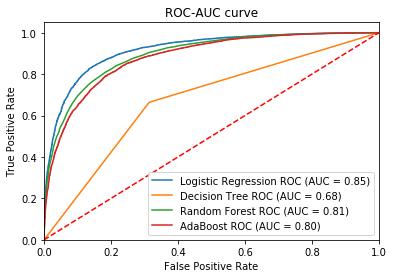

In [30]:
test_models_plot_roc_auc_curve(list_models,
                               "model_name",
                               "estimator",
                               X_train_d2v,
                               X_test_d2v,
                               y_train,
                               y_test)